In [4]:
"""
Kaggle campaign contribution lab – FINAL working script
-------------------------------------------------------
Key fixes:
• Each contributor summary now has a *unique metric column*:
  mean_deg_state_by_state, mean_deg_state_by_type, …, mean_deg_federal_by_stz
• No merge duplicates ⇒ no suffix collisions.
• zip_code kept as string everywhere, so dtypes match.
"""

# ------------------------------------------------------------------
# 0. Imports & settings
# ------------------------------------------------------------------
import re, warnings, numpy as np, pandas as pd, networkx as nx
from networkx.algorithms import bipartite
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# ------------------------------------------------------------------
# 1. Load raw CSV files
# ------------------------------------------------------------------
all_candidates_state_bi   = pd.read_csv("all_candidates_state_bipartite_weighted_network.csv")
winning_candidates_state_bi = pd.read_csv("winning_candidates_state_bipartite_weighted_network.csv")
for df in (all_candidates_state_bi, winning_candidates_state_bi):
    df.index = df["Unnamed: 0"]
    df.drop(columns=["Unnamed: 0", "Unnamed: 1"], inplace=True)

federal_net = pd.read_csv("federal_contributor_top100_contributors_network.csv")
state_net   = pd.read_csv("state_contributor_top100_contributors_network.csv")
for df in (federal_net, state_net):
    df.index = df["Unnamed: 0"]
    df.drop(columns=["Unnamed: 0"], inplace=True)

train_raw = pd.read_csv("training_data.csv")
test_raw  = pd.read_csv("test_data.csv")

# ------------------------------------------------------------------
# 2. Build projected state graphs
# ------------------------------------------------------------------
def build_projected_state_graph(df):
    B = nx.Graph()
    states, candidates = list(df.columns), list(df.index)
    B.add_nodes_from(candidates, bipartite=0)
    B.add_nodes_from(states,     bipartite=1)
    for s in states:
        for c in df[df[s] > 0].index:
            B.add_edge(s, c, weight=df.loc[c, s])

    def my_weight(G, u, v, w="weight"):
        return sum(G[u][nbr][w] + G[v][nbr][w] for nbr in set(G[u]) & set(G[v]))

    bottom_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 1}
    return bipartite.generic_weighted_projected_graph(B, bottom_nodes, weight_function=my_weight)

G_all, G_win = (build_projected_state_graph(all_candidates_state_bi),
                build_projected_state_graph(winning_candidates_state_bi))

# ------------------------------------------------------------------
# 3. Parse top‑100 column metadata
# ------------------------------------------------------------------
def parse_meta(df_net):
    meta = {}
    for col in df_net.columns:
        name = " ".join(col.split(" ")[:-2])
        meta[col] = {
            "name": name,
            "contributor_type": "Non-Individual" if re.search(",", name) is None else "Individual",
            "zip_code": str(col.split(" ")[-2] or "0"),
            "state": col.split(" ")[-1],
        }
    return meta

federal_meta, state_meta = parse_meta(federal_net), parse_meta(state_net)

# ------------------------------------------------------------------
# 4. Build all_data base frame
# ------------------------------------------------------------------
train_raw["train_label"], test_raw["train_label"] = 1, 0
train_raw["index"], test_raw["index"] = train_raw.index, test_raw.index
all_data = pd.concat([train_raw, test_raw], ignore_index=True)

if "zip_code" in all_data.columns:
    all_data["zip_code"] = all_data["zip_code"].astype(str)

# ------------------------------------------------------------------
# 5. Add centrality & communities
# ------------------------------------------------------------------
def add_degree(df, G, col, w=None):
    return df.merge(pd.DataFrame(nx.degree(G, weight=w), columns=["state", col]), how="left")

all_data = (all_data
            .pipe(add_degree, G_all, "d_all")
            .pipe(add_degree, G_win, "d_win")
            .pipe(add_degree, G_all, "d_weight_all", "weight")
            .pipe(add_degree, G_win, "d_weight_win", "weight"))

def add_partition(df, G, label, alg):
    groups = alg(G)
    lbl, num = np.full(len(df), -1, int), np.full(len(df), -1, int)
    for cid, nodes in enumerate(groups):
        m = df["state"].isin(nodes)
        lbl[m], num[m] = cid, len(nodes)
    df[f"{label}"], df[f"{label}_num"] = lbl, num
    return df

all_data = add_partition(all_data, G_all, "greedy_modularity",
                         lambda g: nx.community.greedy_modularity_communities(g, weight="weight"))
all_data = add_partition(all_data, G_win, "greedy_modularity_win",
                         lambda g: nx.community.greedy_modularity_communities(g, weight="weight"))
all_data = add_partition(all_data, G_all, "louvain_communities",
                         nx.community.louvain_communities)
all_data = add_partition(all_data, G_win, "louvain_communities_win",
                         nx.community.louvain_communities)

# ------------------------------------------------------------------
# 6. Contributor summaries with UNIQUE metric names
# ------------------------------------------------------------------
def contributor_features(net, meta, tag):
    """
    Returns four frames with unique metric columns:
      mean_deg_<tag>_by_state
      mean_deg_<tag>_by_type
      mean_deg_<tag>_by_zip
      mean_deg_<tag>_by_stz
    """
    d = pd.DataFrame(nx.degree(nx.from_pandas_adjacency(net), weight="weight"),
                     columns=["name", "deg"])
    ann = d["name"].apply(lambda n: meta.get(n, {})).apply(pd.Series)
    d = pd.concat([d, ann[["state", "contributor_type", "zip_code"]]], axis=1)
    d["zip_code"] = d["zip_code"].astype(str)

    s = d.groupby("state")["deg"].mean().reset_index()\
         .rename(columns={"deg": f"mean_deg_{tag}_by_state"})
    t = d.groupby("contributor_type")["deg"].mean().reset_index()\
         .rename(columns={"deg": f"mean_deg_{tag}_by_type"})
    z = d.groupby("zip_code")["deg"].mean().reset_index()\
         .rename(columns={"deg": f"mean_deg_{tag}_by_zip"})
    stz = (d.groupby(["state", "contributor_type", "zip_code"])["deg"]
             .mean().reset_index()
             .rename(columns={"deg": f"mean_deg_{tag}_by_stz"}))
    return s, t, z, stz

s_state, s_type, s_zip, s_stz = contributor_features(state_net,   state_meta,   "state")
f_state, f_type, f_zip, f_stz = contributor_features(federal_net, federal_meta, "federal")

# ------------------------------------------------------------------
# 6‑B. Merge without duplicate names
# ------------------------------------------------------------------
for df_sub, keys in [
    (s_state, ["state"]), (f_state, ["state"]),
    (s_type,  ["contributor_type"]), (f_type,  ["contributor_type"]),
    (s_zip,   ["zip_code"]), (f_zip,   ["zip_code"]),
    (s_stz,   ["state", "contributor_type", "zip_code"]),
    (f_stz,   ["state", "contributor_type", "zip_code"]),
]:
    all_data = all_data.merge(df_sub, how="left", on=keys)

# ------------------------------------------------------------------
# 7. Encode categoricals, clean NA/inf
# ------------------------------------------------------------------
def ordinalize(df, col):
    labels = df[col].astype(str).unique().tolist()
    df[col] = df[col].astype(str).apply(labels.index)
    return df

for col in ("general_sector", "city", "zip_code",
            "specific_sector", "state", "contributor_type"):
    if col in all_data.columns:
        all_data = ordinalize(all_data, col)

# replace the '#NAME?' strings that slipped through
all_data.replace("#NAME?", 0, inplace=True)

# replace ±∞ only in numeric columns
num_cols = all_data.select_dtypes(include=[np.number]).columns
all_data[num_cols] = all_data[num_cols].replace([np.inf, -np.inf], 0)

# finally, fill any remaining NaNs
all_data.fillna(0, inplace=True)

all_data = pd.get_dummies(
    all_data,
    columns=["specific_sector", "state", "contributor_type",
             "greedy_modularity", "greedy_modularity_win",
             "louvain_communities", "louvain_communities_win"]
)



/var/folders/h5/yfvk0l4921v0kg94n8qt42wc0000gn/T/ipykernel_10480/2142158107.py:38: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train_raw = pd.read_csv("training_data.csv")


/opt/anaconda3/envs/tf_macos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
RF trees: 100%|██████████| 100/100 [11:43<00:00,  7.03s/it]


Training RMSE: 0.1072
Validation RMSE: 0.2847


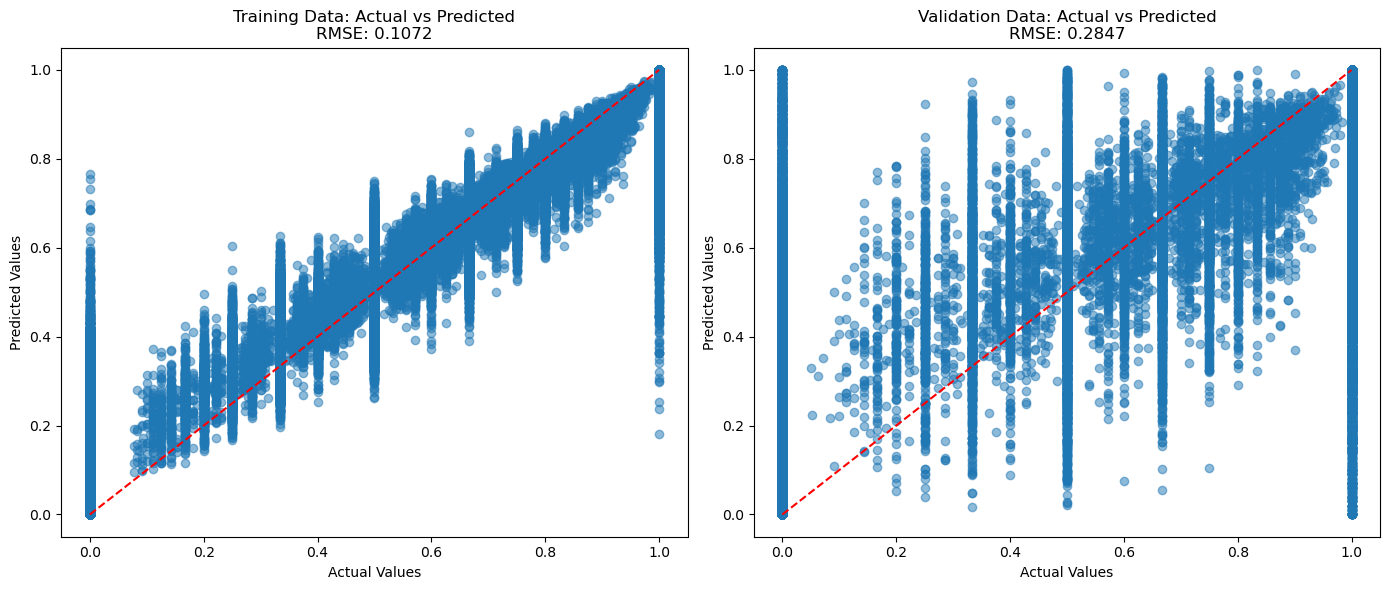

Submission saved → sample_submission_combined_RF.csv
Plot saved → actual_vs_predicted.png


In [8]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1,
    warm_start=True,   # allow growing more trees without discarding previous ones
    random_state=42,
    n_jobs=-1
)

pbar = tqdm(total=100, desc="RF trees")
for i in range(1, 101):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    pbar.update(1)
pbar.close()


# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(metrics.mean_squared_error(y_val, val_pred))

print(f"Training RMSE: {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

In [10]:
all_data.columns.to_list()

['general_sector',
 'city',
 'zip_code',
 'winner_ratio',
 'candidacy_count',
 'candidacy_democratic_count',
 'candidacy_republican_count',
 'contribution_count',
 'contribution_democratic_count',
 'contribution_republican_count',
 'politician_challenger_count',
 'politician_count',
 'politician_democratic_count',
 'politician_incumbency_count',
 'politician_open_pos_count',
 'politician_republican_count',
 'contribution_democratic_sum_2010_usd',
 'contribution_republican_sum_2010_usd',
 'contribution_sum_2010_usd',
 'governor_contributions_sum_2010_usd',
 'house_and_assembly_contributions_sum_2010_usd',
 'senate_contributions_sum_2010_usd',
 'us_house_contributions_sum_2010_usd',
 'us_senate_contributions_sum_2010_usd',
 'candidacy_democratic_ratio',
 'candidacy_republican_ratio',
 'contribution_democratic_count_ratio',
 'contribution_republican_count_ratio',
 'governor_contribution_ratio',
 'house_and_assembly_contribution_ratio',
 'politician_challenger_ratio',
 'politician_democrat

In [11]:
# Step 1: filter out categorical or one-hot columns
cat_prefixes = [
    'specific_sector_', 'state_', 'contributor_type_',
    'greedy_modularity_', 'greedy_modularity_win_',
    'louvain_communities_', 'louvain_communities_win_'
]
original_cats = ['general_sector', 'city', 'zip_code']

# Step 2: define a function to identify non-categorical, numeric vars
def get_numeric_columns(df, target='winner_ratio'):
    return [
        col for col in df.columns
        if col not in original_cats
        and not any(col.startswith(prefix) for prefix in cat_prefixes)
        and df[col].dtype in [np.float64, np.int64]
        and col != 'train_label'
        and col != 'index'
        and col != target  # we'll correlate against it
    ]

# Step 3: get numeric columns
numeric_vars = get_numeric_columns(all_data)

# Step 4: compute correlation with target variable
correlations = all_data[numeric_vars + ['winner_ratio']].corr()['winner_ratio'].sort_values(ascending=False)

# Optional: display top and bottom correlated variables
print("🔼 Top positively correlated variables with winner_ratio:")
print(correlations.head(10))

print("\n🔽 Top negatively correlated variables with winner_ratio:")
print(correlations.tail(10))

# Or store them to inspect
correlations_df = correlations.drop(labels='winner_ratio').reset_index()
correlations_df.columns = ['variable', 'correlation_with_winner_ratio']


🔼 Top positively correlated variables with winner_ratio:
winner_ratio                             1.000000
politician_incumbency_ratio              0.291710
mean_deg_state_by_type                   0.063819
mean_deg_federal_by_type                 0.063674
politician_incumbency_count              0.063291
house_and_assembly_contribution_ratio    0.048330
politician_republican_count              0.030501
politician_count                         0.029948
candidacy_count                          0.028717
candidacy_republican_count               0.028319
Name: winner_ratio, dtype: float64

🔽 Top negatively correlated variables with winner_ratio:
mean_deg_state_by_state       -0.013287
mean_deg_federal_by_state     -0.015806
d_weight_all                  -0.025690
d_weight_win                  -0.026470
politician_challenger_count   -0.042969
politician_open_pos_ratio     -0.147645
politician_challenger_ratio   -0.191890
mean_deg_federal_by_zip             NaN
mean_deg_state_by_stz         

In [ ]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(metrics.mean_squared_error(y_val, val_pred))

print(f"Training RMSE: {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

In [ ]:
ratan

In [ ]:
# ------------------------------------------------------------------
# 8. Train/test split for modeling
# ------------------------------------------------------------------
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]

y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])
test_idx = test_df["index"]
X_test  = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Random Forest + RandomizedSearchCV
# ------------------------------------------------------------------
param_dists = {
    "n_estimators": range(1, 50, 5),
    "max_depth": range(1, 30, 5),
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5],
}

rf = RandomForestRegressor(random_state=42)
rf_cv = RandomizedSearchCV(
    rf, param_dists, n_iter=300, cv=3,
    scoring="neg_mean_squared_error", n_jobs=-1, verbose=1
)
rf_cv.fit(X_train, y_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, rf_cv.predict(X_train)))
print(f"Training RMSE: {train_rmse:,.4f}")

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf_cv.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
